In [1]:
from mfglib.env import Environment
from mfglib.alg.utils import _ensure_free_tensor,tuple_prod
from mfglib.mean_field import mean_field
from typing import Literal, cast
import torch
from mfglib.alg.greedy_policy_given_mean_field import Greedy_Policy
import matplotlib.pyplot as plt
from mfglib.alg import MFOMO,PriorDescent, FictitiousPlay,OnlineMirrorDescent, TwoScaleLearning
from mfglib.metrics import exploitability_score
from mfglib.alg.q_fn import QFn
import scipy
import scienceplots
#plt.style.use(['science','no-latex'])
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


d:\Program Files\anaconda3\envs\mfg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env_instance = Environment.equilibrium_price()

In [3]:
solns, solns_mu, expls, diffs, runtimes = TwoScaleLearning(Q_speed = 0.55, mu_speed=1).solve(env_instance, max_iter=5000, verbose=True)

            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(4,)
	A(3, 3)
	T=4
	r_max=17.0

Algorithm summary:
	OnlineMirrorDescent(Q_speed=0.55, mu_speed=1)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 22.21519 |     1.00000     |          0           |  0.000   |
|  1   | 7.69266  |     0.34628     |          1           |  0.004   |
|  2   | 3.05872  |     0.13769     |          2           |  0.007   |
|  3   | 1.41425  |     0.06366     |          3           |  0.012   |
|  4   | 1.00491  |     0.04524     |          4           |  0.016   |
|  5   | 0.99757  |     0.04490     |          5           |  0.019   |
|  6   | 0.93728  |     0.04219     |        

In [6]:
torch.save(solns, "results/production_pi_record.pt")
torch.save(solns_mu, "results/production_nu_record.pt")
torch.save(expls, "results/production_exp_record.pt")
torch.save(diffs, "results/production_diff_record.pt")
torch.save(runtimes, "results/production_time_record.pt")


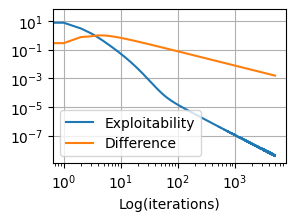

In [7]:
# expls = torch.load("results/beach_exp_record.pt")
# diffs = torch.load("results/beach_diff_record.pt")
plt.figure(figsize=(3, 2))
plt.plot(expls, label='Exploitability') 
plt.plot(diffs, label='Difference') 
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(iterations)')
plt.savefig('results/production_converge',dpi=300)

plt.show()

In [9]:
pi = solns[-1]
nu = solns_mu[-1]

env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
print(L.shape)

print(L[0])

torch.Size([5, 4, 3, 3])
tensor([[[9.9922e-01, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.9112e-04, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.1888e-04, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.6251e-04, 0.0000e+00, 0.0000e+00],
         [6.5093e-06, 0.0000e+00, 0.0000e+00]]])


tensor([[9.9922e-01, 3.9112e-04, 2.1888e-04, 1.6902e-04],
        [9.9961e-01, 2.2539e-04, 1.6251e-04, 0.0000e+00],
        [9.9984e-01, 1.6251e-04, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])


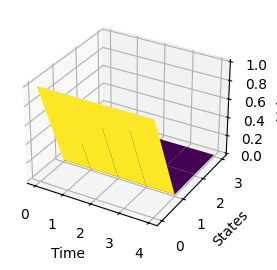

In [5]:
# solns = torch.load("results/beach_pi_record.pt")
# solns_mu = torch.load("results/beach_nu_record.pt")

pi = solns[-1]
nu = solns_mu[-1]

env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
mu = L.sum(dim=tuple(range(2, L.ndim)))
print(mu)
mu_np = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_np, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("States")
ax.set_zlabel("Value")

#plt.savefig('results/beach_CMFE',dpi=300)

plt.show()

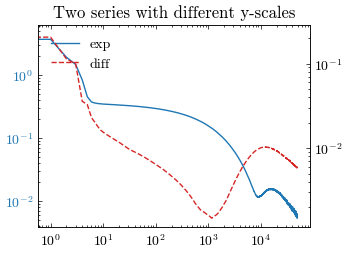

In [66]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, ax1 = plt.subplots()
ax1.plot(expls, color = colors[0], label='exp')
# ax1.set_xlabel('x')
# ax1.set_ylabel('y1 (x²)', color='g')
ax1.tick_params(axis='y', labelcolor=colors[0])


# create a second y‐axis
ax2 = ax1.twinx()
ax2.plot(diffs, color = colors[3], linestyle = '--', label='diff')
#ax2.set_ylabel('diff')
ax2.tick_params(axis='y')

# optional: combine legends
lines, labels = ax1.get_lines() + ax2.get_lines(), [l.get_label() for l in ax1.get_lines()+ax2.get_lines()]
ax1.legend(lines, labels, loc='upper left')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.title("Two series with different y-scales")
plt.show()

            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(4,)
	A(3, 3)
	T=4
	r_max=17.0

Algorithm summary:
	OnlineMirrorDescent(alpha=1.0)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 22.21519 |     1.00000     |          0           |  0.000   |
|  1   | 5.64529  |     0.25412     |          1           |  0.005   |
|  2   | 1.49283  |     0.06720     |          2           |  0.010   |
|  3   | 0.45786  |     0.02061     |          3           |  0.016   |
|  4   | 0.16684  |     0.00751     |          4           |  0.019   |
|  5   | 0.06980  |     0.00314     |          5           |  0.023   |
|  6   | 0.03104  |     0.00140     |          6           |

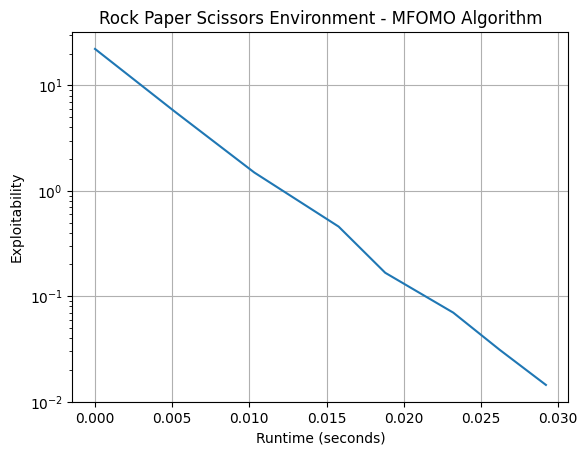

In [10]:
env_instance = Environment.equilibrium_price()
solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=True)
plt.semilogy(runtimes, exploitability_score(env_instance, solns)) 

plt.grid(True)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Exploitability")
plt.title("Rock Paper Scissors Environment - MFOMO Algorithm")
plt.show()

In [13]:
pi = solns[-1]
print(pi.shape)
L = mean_field(env_instance, pi)
print(L[0])


torch.Size([5, 4, 3, 3])
tensor([[[2.5000e-01, 4.7853e-11, 6.1198e-23],
         [1.1943e-11, 2.2861e-21, 2.9236e-33],
         [4.7443e-28, 9.0812e-38, 0.0000e+00]],

        [[9.1009e-04, 1.1639e-15, 3.7457e-29],
         [2.4909e-01, 4.7679e-11, 6.0976e-23],
         [9.8948e-18, 1.8940e-27, 2.4222e-39]],

        [[6.1013e-06, 1.9635e-19, 1.7905e-22],
         [2.4994e-01, 3.1964e-13, 1.0287e-26],
         [5.6882e-05, 1.0888e-14, 1.3925e-26]],

        [[1.4851e-07, 1.3543e-10, 1.2349e-13],
         [2.4176e-01, 7.7804e-15, 7.0948e-18],
         [8.2352e-03, 1.0532e-14, 3.3893e-28]]])


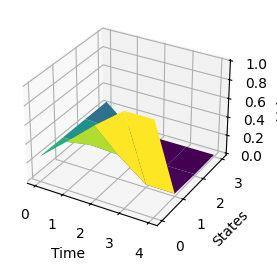

In [10]:
pi = solns[-1]

L = mean_field(env_instance, pi)
mu = L.sum(dim=tuple(range(2, L.ndim)))
mu_np = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_np, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("States")
ax.set_zlabel("Value")

#plt.savefig('results/beach_MFE',dpi=300)

plt.show()

In [5]:
torch.save(solns, "results/beach_MFE_pi_record.pt")
torch.save(expls, "results/beach_MFE_exp_record.pt")
torch.save(runtimes, "results/beach_MFE_time_record.pt")
